# 0 IMPORTS

In [36]:
import pandas as pd
import numpy as np
import inflection
import math
import datetime
from datetime import timedelta


import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image


## 0.1 Helper Functions

In [2]:
def vscode_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()


In [3]:
vscode_settings()

## 0.2 Load data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Confirm NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance(if NA is listed, it means the competitor is very far from my store or someone forgot to register. Therefore, including the maximum value signifies this.)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month (include the month of the sale, as a competitor's store can interfere with sales growth)
df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].month 
                                                 if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1))
#competition_open_since_year (include the year of the sale, as a competitor's store can interfere with sales growth)
df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                 if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1))              
#promo2_since_week (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
df1['promo2_since_week'] = (df1.apply(lambda x: x['date'].week 
                                                 if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1))       
#promo2_since_year (this means that the store didn't participate in promotion 2; there was no continuity from promotion 1 to promotion 2)
df1['promo2_since_year'] = (df1.apply(lambda x: x['date'].year 
                                                 if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1))         
#promo_interval
month_map = {
                1: 'Jan',
                2: 'Feb',
                3: 'Mar',
                4: 'Apr',
                5: 'May',
                6: 'Jun',
                7: 'Jul',
                8: 'Aug',
                9: 'Sep',
                10: 'Oct',
                11: 'Nov',
                12: 'Dec',
            }
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = (df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval']
                                                      .split(',') else 0, axis=1))

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [12]:
df1.sample(5).T

,375780,367708,593955,1002101,56936
store,102,510,446,502,72
day_of_week,1,3,3,1,3
date,2014-08-04 00:00:00,2014-08-13 00:00:00,2014-01-15 00:00:00,2013-01-14 00:00:00,2015-06-10 00:00:00
sales,11784,6259,4115,9320,3335
customers,1487,737,571,1391,397
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,1,0,0,0
store_type,a,a,a,a,a


## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']] = (df1
                                                                                                                  [['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']].astype(int))

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


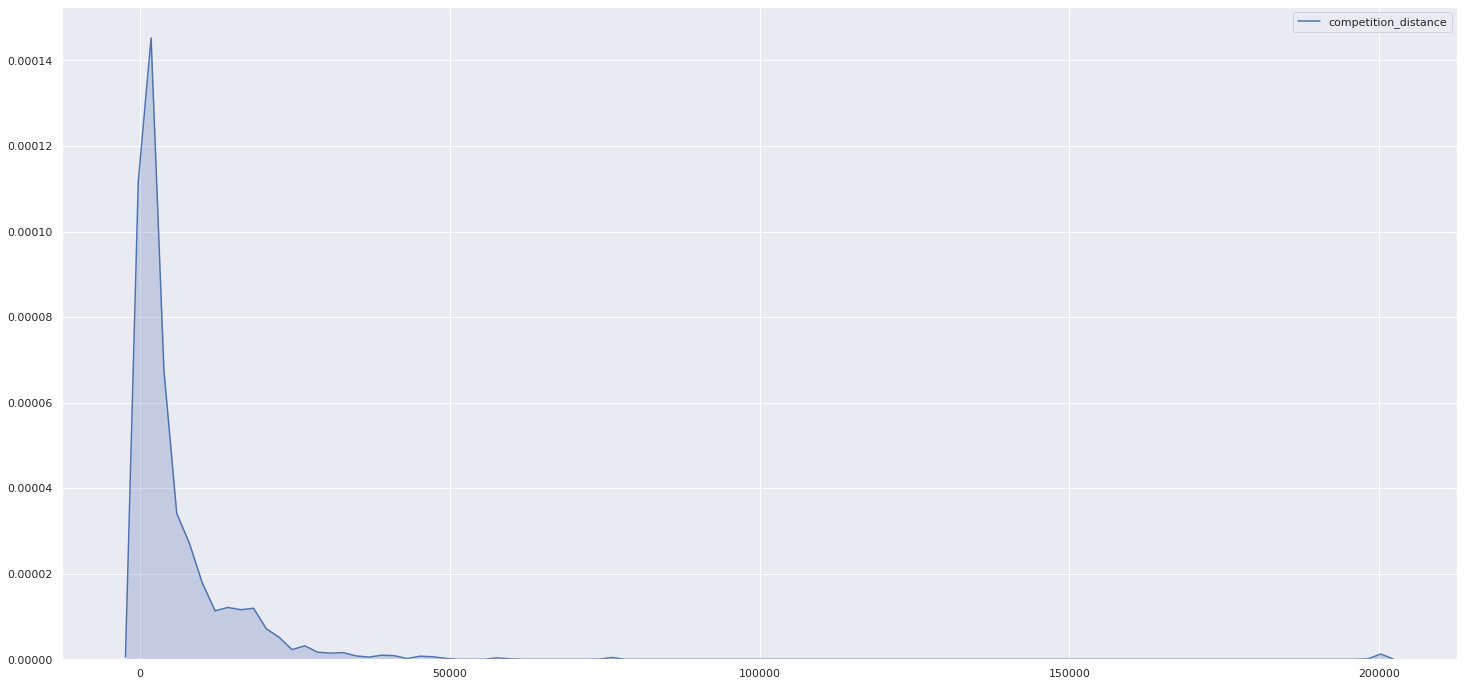

In [17]:
sns.kdeplot(df1['competition_distance'], shade=True)

### 1.7.1 Categorical attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

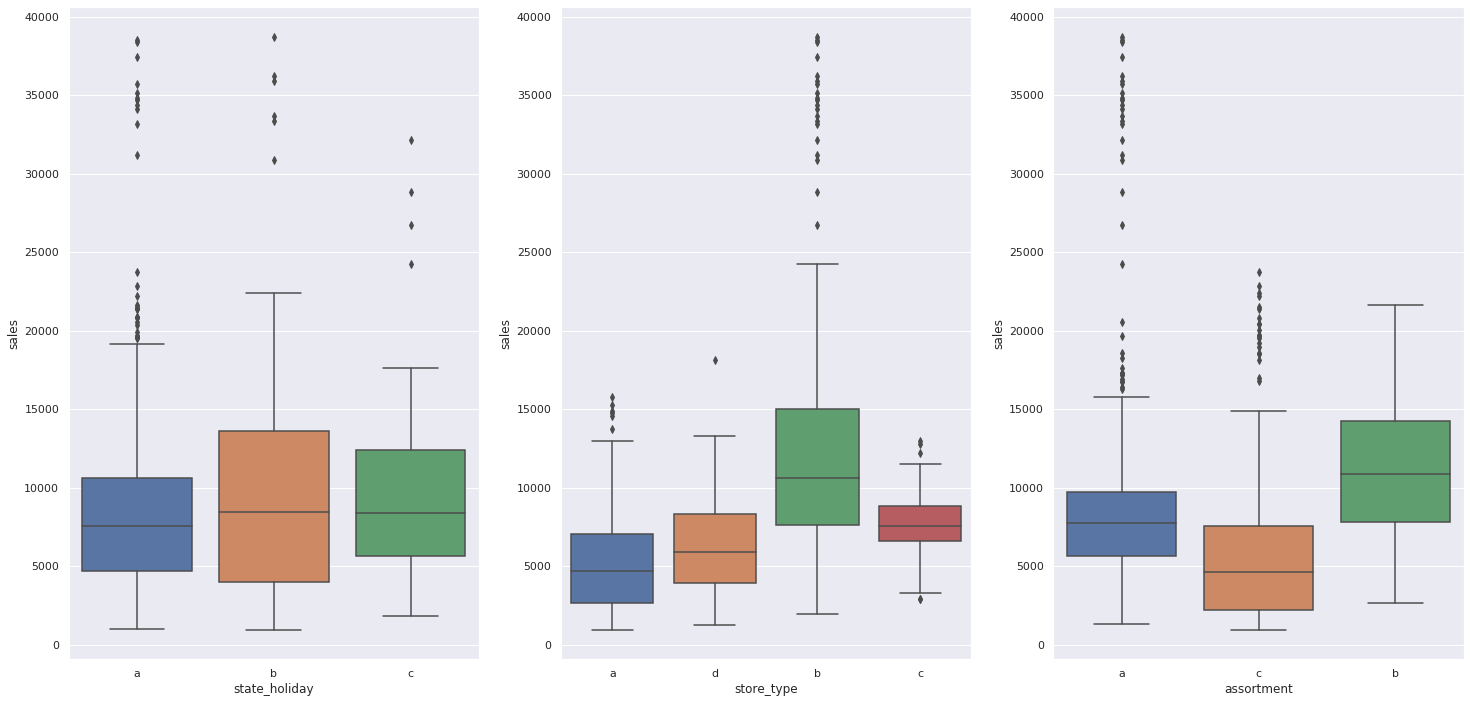

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

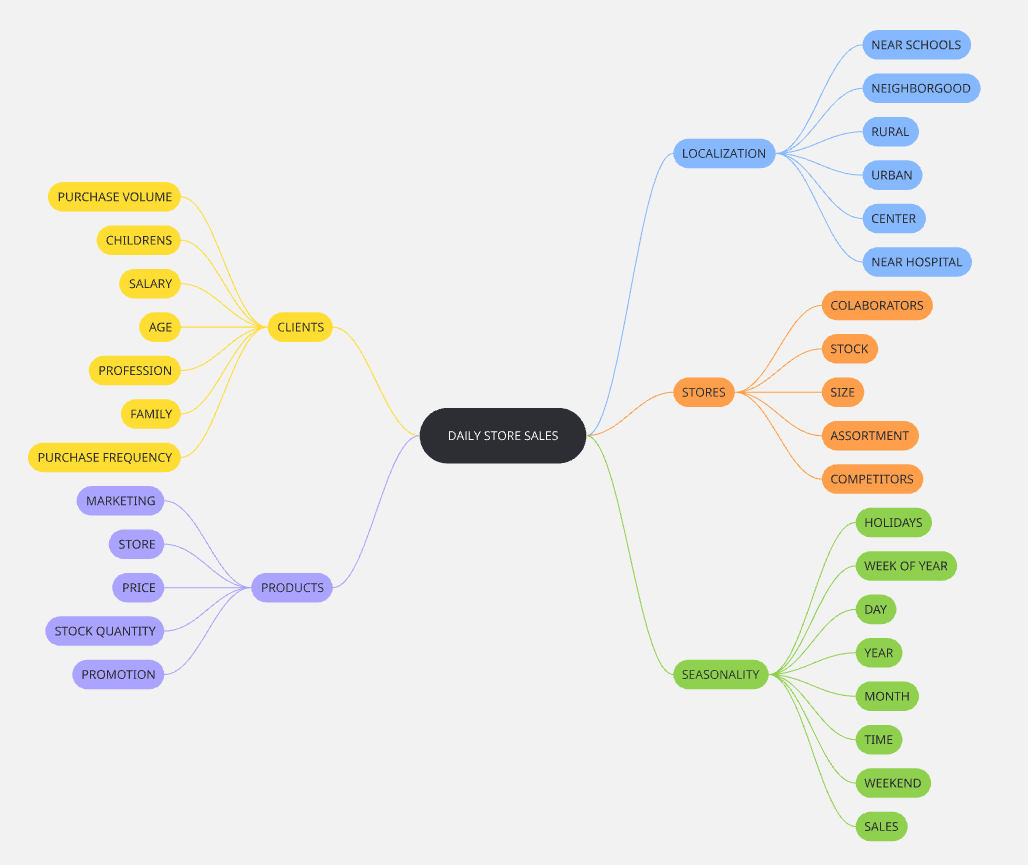

In [22]:
Image('img/mind_map.png')

## 2.1 Creation of Hypotheses

### 2.1.1 Hypotheeses Store

**1 -** Lojas com numero maior de funcionarios deveriam vender mais.

**2 -** Lojas com maior capacidade de estoque deveriam vender mais.

**3 -** Lojas com maior porte deveriam vender mais.

**4 -** Lojas com maior variedade deveriam vender mais.

**5 -** Lojas com competidores mais proximos deveriam vender menos.

**6 -** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hypotheeses Product

**1 -** Lojas que investem mais em Marketing deveriam vender mais.

**2 -** Lojas com maior exposicao de produtos deveriam vender mais.

**3 -** Lojas com produtos com preco menor deveriam vender mais.

**4 -** Lojas com promocoes mais agressivas deveriam vender mais.

**5 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6 -** Lojas com mais dias de promocao deveriam vender mais.

**7 -** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.2 Hypotheeses Seasonality

**1 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**2 -** Lojas deveriam vender mais ao longo dos anos.

**3 -** Lojas deveriam vender mais no segundo semestre do ano

**4 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5 -** Lojas deveriam vender menos aos finais de semana.

**6 -** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final List - Hypotheses

**1 -** Lojas com maior variedade deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [41]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday
df2['state_holiday'] = (df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                   if x == 'b' else 'christmas' if x == 'c' else 'regular_day'))


In [42]:
df2.sample(5).T

,853123,635229,587435,653863,250998
store,934,465,616,144,717
day_of_week,2,1,2,5,2
date,2013-05-28 00:00:00,2013-12-09 00:00:00,2014-01-21 00:00:00,2013-11-22 00:00:00,2014-12-16 00:00:00
sales,7488,7108,9680,8259,9807
customers,756,612,893,801,839
open,1,1,1,1,1
promo,1,0,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,d,a,a,d
